# Reference model for atmospheric dispersion

by myriam.rodrigues@obspm.fr

This notebook computes the shift of the image spot due to the atmospheric difraction for the MOSAIC bands. It assumes a single reference wavelength for guiding, applied to all bands.

### Change log 

Date | Description
-----| -----------
04/02/2022|Draft 



In [1]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
from astropy.table import Table, Column
from astropy.io import ascii

from Atmospheric_diffraction import *
%matplotlib inline 

plt.rcParams['figure.figsize'] = (12,4)

The plot below shows the shift in arcsec of the spot image in the MOONS bandwith, at airmass of 1.15 assuming a reference wavelength at 0.6 microns.

In [16]:
#change values here to test other airmass and reference wavelength 
airmass = 1.15 * u.dimensionless_unscaled #30 degrees ZA
atm_ref_wav = 1 * u.micron

Resolution Band   AD_lmin      AD_lcen     AD_lmax  
---------- ---- ------------ ----------- -----------
        LR    B   -0.8132536 -0.59609044  -0.4068645
        LR    V   -0.4299676 -0.32756695   -0.192581
        LR    R  -0.20314974 -0.13480291 -0.06302474
        LR   IY  -0.08965135 -0.03230428 0.014909242
        LR    J 0.0025562814 0.037255786  0.06280429
        LR    H   0.06511085   0.0798697  0.09154472


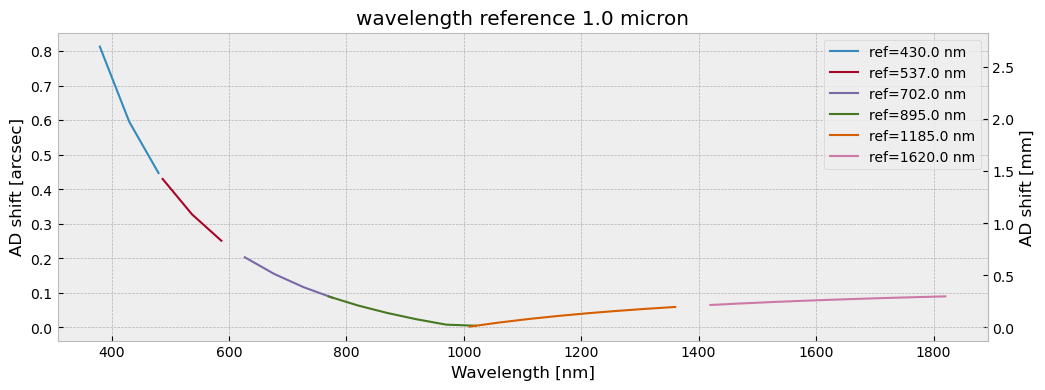

In [17]:
Path_Inst_config = './Architecture_parameters/'
Config_tel = ConfigObj(Path_Inst_config+'Telescope_conf.ini')

conditions = {}
conditions['temperature']= float(Config_tel['EnvConditions']['AirTemperature']) * u.deg_C
conditions['humidity']= float(Config_tel['EnvConditions']['AirHumidity']) * u.percent
conditions['pressure']= float(Config_tel['EnvConditions']['AirPressure']) * u.mBa

#save resuts in table
t_AD = Table(names=('Resolution','Band', 'AD_lmin', 'AD_lcen','AD_lmax'), dtype=('S2','S2', 'f4', 'f4', 'f4'))
t_AD['AD_lmin'].description = 'Shift in arcsec at min of the band'
t_AD['AD_lcen'].description = 'Shift in arcsec at center of the band'
t_AD['AD_lmax'].description = 'Shift in arcsec at max of the band'
table_file = 'Atmos_shift_ref%s_airmass%s.ascii' % (atm_ref_wav.value,airmass)

#Convert shift in arcsec to mm in focal plane
Plate_scale = float(Config_tel['OpticalInterfaces']['Plate_Scale']) #* u.arcsec / u.mm
T_arc = lambda T_mm: T_mm * Plate_scale
T_mm = lambda T_arc: T_arc / Plate_scale

fig, ax = plt.subplots()
ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
plt.style.use('bmh')

Conf_files = [Path_Inst_config+'VIS_channel_conf.ini', Path_Inst_config+'NIR_channel_conf.ini']
for config_file in Conf_files:
    Config = ConfigObj(config_file)
    Bands = Config['LR']['Bands'].keys()
    for band in Bands : 
      wave = np.arange(int(Config['LR']['Bands'][band]['wave_min']),int(Config['LR']['Bands'][band]['wave_max']),50) * u.nm
      wave_c = np.mean(wave)
      wave_tb = [int(Config['LR']['Bands'][band]['wave_min']),int(wave_c.value), int(Config['LR']['Bands'][band]['wave_max'])] * u.nm
      shift = Atmospheric_diffraction(wave, airmass, atm_ref_wav, conditions)
      plt.plot(wave, np.abs(shift),  linewidth=1.5, label= 'ref=%s' %(wave_c))
      shift_t = Atmospheric_diffraction(wave_tb, airmass, atm_ref_wav, conditions)
      t_AD.add_row(["LR",band,shift_t[0],shift_t[1],shift_t[2]]) 

plt.title('wavelength reference %s' %(atm_ref_wav))
plt.legend(loc='best')
ax.set_ylabel('AD shift [arcsec]')
ax2.set_ylabel('AD shift [mm]')
ax.set_xlabel('Wavelength [nm]')

t_AD.pprint()
t_AD.write(table_file, format='ascii.commented_header', overwrite=True, formats={'AD_lmin': '%6.3f', 'AD_lcen': '%6.3f', 'AD_lmax': '%6.3f'})      

Text(0.5, 0, 'Wavelength [mu]')

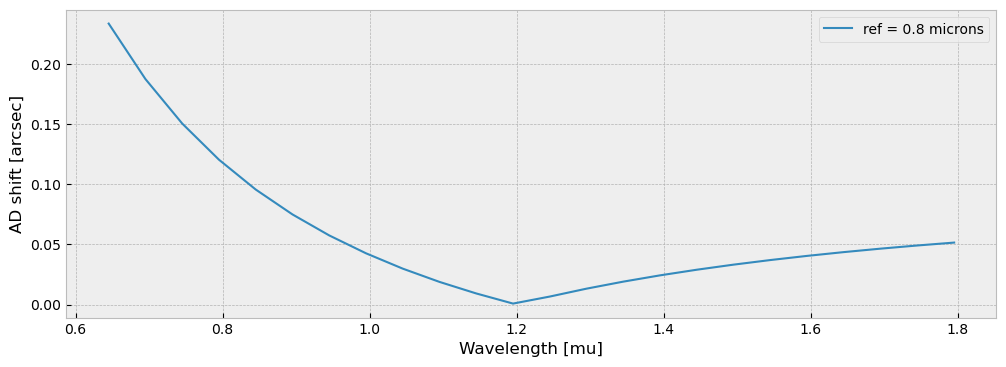

In [18]:
#Toy model for other tests
airmass = 1.15 * u.dimensionless_unscaled #30 degrees ZA
atm_ref_wav = 1.2 * u.micron
wave = np.arange(0.645,1.8,0.05) * u.micron
conditions['temperature']=11.5 * u.deg_C
conditions['humidity']=14.5 * u.percent
conditions['pressure']=743.0 * u.mBa

shift = Atmospheric_diffraction(wave, airmass, atm_ref_wav, conditions)  
plt.figure(1)
plt.style.use('bmh')
plt.plot(wave, np.abs(shift),  linewidth=1.5, label= 'ref = 0.8 microns')
plt.legend(loc='best')
plt.ylabel('AD shift [arcsec]')
plt.xlabel('Wavelength [mu]')